In [104]:
import tensorflow as tf
import keras
import keras.backend as K

print (tf.__version__, keras.__version__)

import os
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import numpy as np
import random
from random import randint
import pandas as pd
import seaborn as sns
import json

import cv2 as cv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from PIL import Image
from glob import glob
from tqdm import tqdm, tqdm_notebook

%pylab inline
%matplotlib inline

sys.path.append('script/')
from metrics import *
from ressources import *
from model import *
from weights_path import *

9446


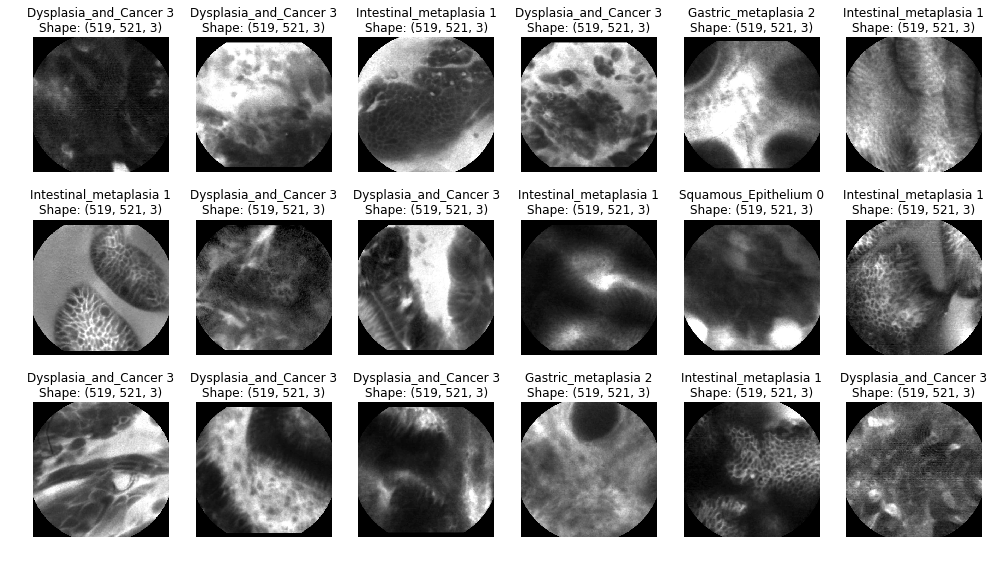

In [107]:
name = 'resnet'
height, width, channel = 224, 224, 3
batch_size = 32
trainDir = 'TrainingSetImagesDir/'
testDir = 'TestSetImagesDir/'

df_train = pd.read_csv('TrainingSet_20aimVO.csv')
df_test = pd.read_csv('Mauna_Kea_Supp_Material/test_data_order.csv')

classes = ['Squamous_Epithelium', 'Intestinal_metaplasia', 'Gastric_metaplasia', 'Dysplasia_and_Cancer']

labeled_files = glob('TrainingSetImagesDir/*.png')

labeled_files = [lbl for lbl in labeled_files if  lbl.split(os.path.sep)[-1] in list(df_train.image_filename.values)]
print (len(labeled_files))

id_label_map = {k:v for k, v in zip(df_train.image_filename.values, df_train.class_number.values)}

cols = 6
rows = 4

randomLst = []
for i in range(0, (rows * cols)):
    randomLst.append(randint(0, len(labeled_files)))

plot_imgs(randomLst, classes, labeled_files, id_label_map, cols=6, rows=3)

In [108]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

In [109]:
nb1, nb2 = 0, 1

In [162]:
df_train = pd.read_csv('TrainingSet_20aimVO.csv')
df_train = df_train.loc[(df_train['class_number'] == 2) | (df_train['class_number'] == 3)]

In [163]:
# (df_train['class_number'] == 0) | (df_train['class_number'] == 2)

In [164]:
df_train.tail()

,image_filename,class_number
9441,im_114_55.png,3
9442,im_7_55.png,3
9443,im_52_55.png,3
9444,im_10_55.png,3
9445,im_111_55.png,3


In [165]:
version = 'binary23'

In [166]:
from keras.losses import binary_crossentropy, categorical_crossentropy

In [167]:
# K.clear_session()

# weights = nasnet_path
# pretrained_model = NASNetMobile(weights=weights, include_top=False)
# # model = get_model_1(pretrained_model, 4, 0)
# model = get_model_classif_nasnet(pretrained_model, 2, 0, binary_crossentropy)

In [168]:
K.clear_session()
weights = resnet50_path
pretrained_model = ResNet50(weights=weights, include_top=False)
model = get_model_1(pretrained_model, 2, 0, binary_crossentropy)
# model = get_model_classif_nasnet(pretrained_model, 4, 0)
# model.load_weights('model2/resnet_2_weights.13-0.04-0.99-0.03-0.99.hdf5')

In [169]:
df_train['class_number'] = df_train['class_number'].astype('str')
train, val = train_test_split(df_train, test_size=0.10, random_state=42)

In [170]:
datagen = datagen_create(True)
train_gen=datagen.flow_from_dataframe(directory=trainDir,
                                        dataframe=train,
                                        x_col="image_filename",
                                        y_col="class_number",
                                        class_mode="categorical",
                                        target_size=(height, width),
                                        batch_size=batch_size,
                                        shuffle=True,
                                        seed=42)
datagen = datagen_create()
val_gen = datagen.flow_from_dataframe(directory=trainDir,
                                        dataframe=val,
                                        x_col="image_filename",
                                        y_col="class_number",
                                        class_mode="categorical",
                                        target_size=(height, width),
                                        batch_size=batch_size,
                                        shuffle=True,
                                        seed=42)

Found 4320 validated image filenames belonging to 2 classes.
Found 480 validated image filenames belonging to 2 classes.


In [174]:
name = 'resnet_{}'.format(version)
filepath = './model2/{}_{}'.format(name, 'weights.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5')
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.5,
                              patience=1,
                              verbose=1,
                              mode='max',
                              min_lr=0.00001)

earlyStp = EarlyStopping(monitor='val_loss',
                         min_delta=1e-5,
                         patience=5,
                         verbose=1,
                         mode='auto')

class_weights = class_weight.compute_class_weight(
   'balanced',
    np.unique(train_gen.classes), 
    train_gen.classes)

In [172]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = len(train_gen.filenames) // batch_size,
    validation_data = val_gen,
    validation_steps = len(val_gen.filenames) // batch_size,
    epochs = 30,
    verbose = 1,
        callbacks = [checkpoint, reduce_lr, earlyStp],
        class_weight = class_weights)

Epoch 1/30
135/135 [==============================] - 64s 474ms/step - loss: 0.2525 - acc: 0.8998 - val_loss: 0.1228 - val_acc: 0.9500

Epoch 00001: val_acc improved from -inf to 0.95000, saving model to ./model2/resnet_binary23_weights.01-0.25-0.90-0.12-0.95.hdf5
Epoch 2/30
135/135 [==============================] - 54s 402ms/step - loss: 0.1266 - acc: 0.9500 - val_loss: 0.1398 - val_acc: 0.9583

Epoch 00002: val_acc improved from 0.95000 to 0.95833, saving model to ./model2/resnet_binary23_weights.02-0.13-0.95-0.14-0.96.hdf5
Epoch 3/30
135/135 [==============================] - 54s 402ms/step - loss: 0.1017 - acc: 0.9639 - val_loss: 0.1272 - val_acc: 0.9583

Epoch 00003: val_acc did not improve from 0.95833

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/30
135/135 [==============================] - 54s 402ms/step - loss: 0.0641 - acc: 0.9771 - val_loss: 0.1686 - val_acc: 0.9458

Epoch 00004: val_acc did not improve from 0.95833

Epoch 00004: 

In [173]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = len(train_gen.filenames) // batch_size,
    validation_data = val_gen,
    validation_steps = len(val_gen.filenames) // batch_size,
    epochs = 30,
    verbose = 1,
        callbacks = [checkpoint, reduce_lr, earlyStp],
        class_weight = class_weights)

Epoch 1/30
135/135 [==============================] - 54s 402ms/step - loss: 0.0585 - acc: 0.9787 - val_loss: 0.0149 - val_acc: 0.9938

Epoch 00001: val_acc improved from 0.95833 to 0.99375, saving model to ./model2/resnet_binary23_weights.01-0.06-0.98-0.01-0.99.hdf5
Epoch 2/30
135/135 [==============================] - 54s 402ms/step - loss: 0.0425 - acc: 0.9854 - val_loss: 0.5153 - val_acc: 0.9062

Epoch 00002: val_acc did not improve from 0.99375

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 3/30
135/135 [==============================] - 54s 402ms/step - loss: 0.0427 - acc: 0.9836 - val_loss: 0.0231 - val_acc: 0.9896

Epoch 00003: val_acc did not improve from 0.99375

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 4/30
135/135 [==============================] - 54s 402ms/step - loss: 0.0352 - acc: 0.9870 - val_loss: 0.0082 - val_acc: 0.9958

Epoch 00004: val_acc improved from 0.99375 to 0.99583, saving model to ./model

In [175]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = len(train_gen.filenames) // batch_size,
    validation_data = val_gen,
    validation_steps = len(val_gen.filenames) // batch_size,
    epochs = 30,
    verbose = 1,
        callbacks = [checkpoint, reduce_lr, earlyStp],
        class_weight = class_weights)

Epoch 1/30
135/135 [==============================] - 54s 403ms/step - loss: 0.0301 - acc: 0.9898 - val_loss: 0.0037 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to ./model2/resnet_binary23_weights.01-0.03-0.99-0.00-1.00.hdf5
Epoch 2/30
135/135 [==============================] - 54s 402ms/step - loss: 0.0246 - acc: 0.9912 - val_loss: 0.0068 - val_acc: 0.9958

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/30
135/135 [==============================] - 54s 403ms/step - loss: 0.0266 - acc: 0.9898 - val_loss: 0.0313 - val_acc: 0.9938

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/30
135/135 [==============================] - 54s 403ms/step - loss: 0.0318 - acc: 0.9882 - val_loss: 0.0251 - val_acc: 0.9896

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/30
135/135 [==============================] - 54s 403ms/step - loss: 0.0229 - acc: 0.9914 - val_loss: 9.6242e-04 - val_acc: 1.0000

Epoch 00005: val_acc did not improve 

KeyboardInterrupt: 

In [ ]:
# model.load_weights('./model2/resnet_binary13_weights.12-0.02-0.99-0.00-1.00.hdf5')

In [176]:
path_to_weights = 'resnet_{}.hdf5'.format(version)
model.save_weights(path_to_weights)
print (path_to_weights)

resnet_binary23.hdf5


In [177]:
datagen = ImageDataGenerator(
            rescale=1./255, 
        )
validation_generator = datagen.flow_from_dataframe(directory=trainDir,
                                            dataframe=val,
                                            x_col="image_filename",
                                            y_col="class_number",
                                            class_mode='categorical',
                                            target_size=(height, width),
                                            batch_size=1,
                                            shuffle=False,
                                            pickle_safe = True,
                                            workers = 1,
                                            seed=42)

Found 480 validated image filenames belonging to 2 classes.


In [178]:
val_predictions = model.predict_generator(validation_generator,
                                          steps=(len(validation_generator.filenames)),
                                          verbose=1)

480/480 [==============================] - 7s 14ms/step


In [179]:
y_pred_val_classes = np.argmax(val_predictions, axis=1)
y_pred_val_max_probas = np.max(val_predictions, axis=1)

In [180]:
confusion_matrix(validation_generator.classes, y_pred_val_classes)

array([[135,   0],
       [  2, 343]])

In [181]:
classes = ['0', '1']

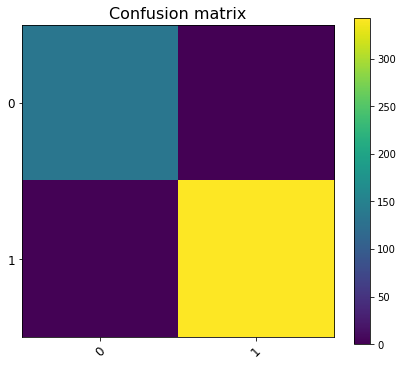

accuracy: 0.9958333333333333


In [182]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(7, 6))
    plt.title('Confusion matrix', fontsize=16)
    plt.imshow(confusion_matrix(y, y_pred))
    plt.xticks(np.arange(2), classes, rotation=45, fontsize=12)
    plt.yticks(np.arange(2), classes, fontsize=12)
    plt.colorbar()
    plt.show()
    print("accuracy:", accuracy_score(y, y_pred))
plot_confusion_matrix(validation_generator.classes, y_pred_val_classes)

In [183]:
print(classification_report(validation_generator.classes, y_pred_val_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       135
           1       1.00      0.99      1.00       345

    accuracy                           1.00       480
   macro avg       0.99      1.00      0.99       480
weighted avg       1.00      1.00      1.00       480

